# Что тут вообще происходит

* Обучаемся классифицировать события на "Монте-карло с Ks" и "Монте-карло без Ks"
* Формат входных данных - 2 склеенных "картинки", полученных методом Retina с сеткой прямых 64x64 каждая
 * Если вкратце:
   * одна ретина "находится" сразу за Velo, как раньше, 
   * вторая - в дальней части и под углом ~pi/4 к оси Z
 * Если подробнее - смотри в тетрадку про ретину
* Модель - 
 * тупая логистическая регрессия над картинками с L1 регуляризацией
 * та же самая тупая логистическая регрессия но над SVD-представлением картинок
* Оценка качества
 * One-time валидация
 * Метрики - точность и площадь под операционной характеристикой (AUC)

In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np

# Данные 
* retina-представления событий с ks и без.

In [3]:
sig1 = np.load("/mnt/KSfinder/mc_sig_retina1.npy")
bg1 = np.load("/mnt/KSfinder/mc_bg_down_retina1.npy")
sig0 = np.load("/mnt/KSfinder/mc_sig_retina0.npy")
bg0 = np.load("/mnt/KSfinder/mc_bg_down_retina0.npy")

In [4]:
#join 2 retinas
sig = np.concatenate([sig0,sig1], -1)
bg = np.concatenate([bg0,bg1],-1)

In [5]:
X = np.vstack([sig,bg])
y = np.zeros( len(sig)+len(bg))
y[:len(sig)] = 1
y.shape

(10000,)

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

<matplotlib.colorbar.Colorbar instance at 0x7fb307f87440>

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


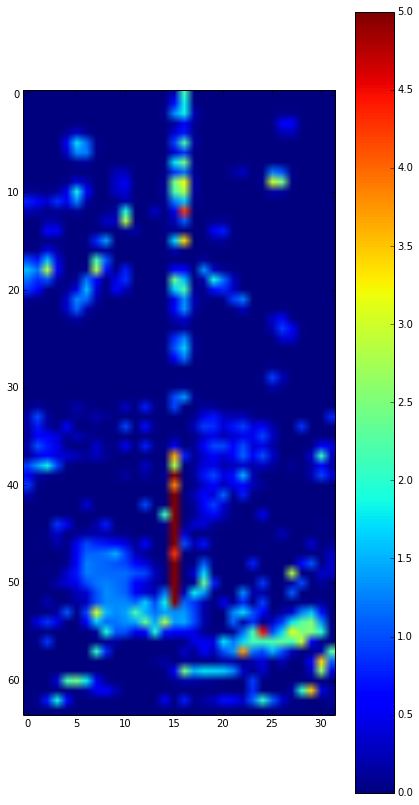

In [7]:
from random import choice
i = choice(range(len(X)))
plt.figure(figsize=[7,14])
plt.imshow(X[i].reshape(64,32),vmin=0,vmax=5)
plt.colorbar()

# нарезка данных
* на обучение и тест

In [8]:
from sklearn.cross_validation import train_test_split
Xtr,Xts,Ytr,Yts = train_test_split(X,y,test_size=0.25)
Xtr.shape,Xts.shape

((7500, 2048), (2500, 2048))

# SVD
 * Выделим линейные компоненты из данных с помощью SVD разложения
 * тестовая выборка при этом также не трогается

In [9]:
from sklearn.decomposition import TruncatedSVD

In [10]:
pca = TruncatedSVD(n_components=256).fit(Xtr.reshape(len(Xtr),np.prod(Xtr.shape[1:])))
#Просто поверь, что svd-разложение называется pca; так надо.

In [11]:
Xtr_pca = pca.transform(Xtr.reshape(len(Xtr),np.prod(Xtr.shape[1:])))
Xts_pca = pca.transform(Xts.reshape(len(Xts),np.prod(Xts.shape[1:])))


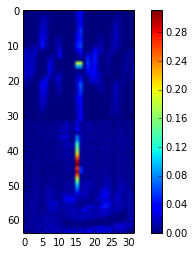

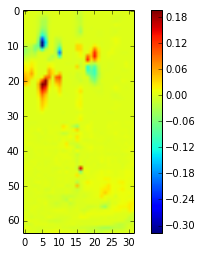

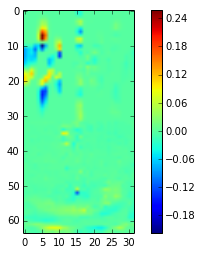

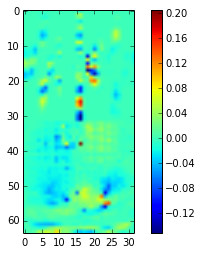

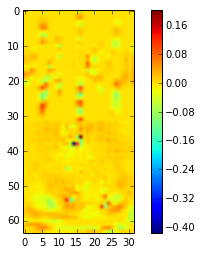

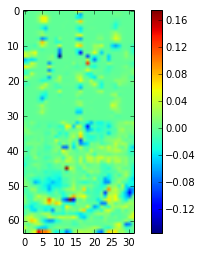

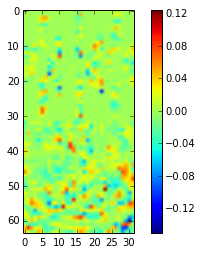

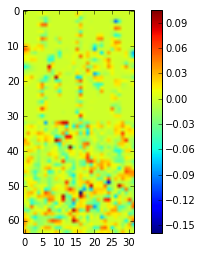

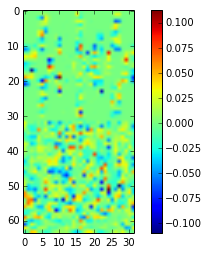

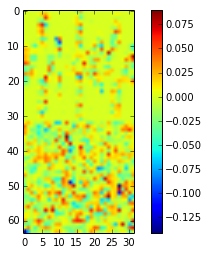

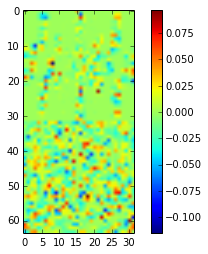

In [12]:
for i in range(0,256,25):
    plt.imshow(pca.components_[i].reshape(-1,32))
    plt.colorbar()
    plt.show()

In [13]:
pca.components_.shape

(256, 2048)

# Поучим линейную модель
* В качестве признаков будем использовать компоненты SVD разложения

In [14]:
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV

In [15]:
model = LogisticRegression(penalty='l2',C=.01).fit(Xtr_pca,Ytr)

In [16]:
from sklearn.metrics import accuracy_score
print "train accuracy",accuracy_score(Ytr,model.predict(Xtr_pca))
print "test accuracy",accuracy_score(Yts,model.predict(Xts_pca))

train accuracy 0.9916
test accuracy 0.9912


In [17]:
from sklearn.metrics import roc_auc_score
print "train auc",roc_auc_score(Ytr,model.predict_proba(Xtr_pca)[:,1])
print "test auc",roc_auc_score(Yts,model.predict_proba(Xts_pca)[:,1])

train auc 0.999890275524
test auc 0.99970303924


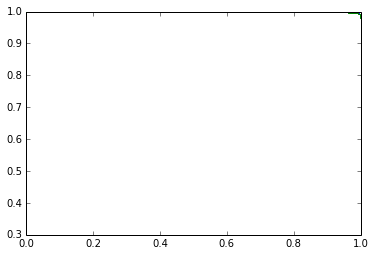

In [18]:
from sklearn.metrics import roc_curve

fpr,tpr,_ = roc_curve(Ytr,model.predict_proba(Xtr_pca)[:,1])
plt.plot(1-fpr,tpr)
fpr,tpr,_ = roc_curve(Yts,model.predict_proba(Xts_pca)[:,1])
plt.plot(1-fpr,tpr)

# Простая-тупая логистическая регрессия
 * Признаки - "пиксели" Retina-представления
 * Более строгая L2 регуляризация

In [19]:
from sklearn.cross_validation import train_test_split
Xtr,Xts,Ytr,Yts = train_test_split(X.reshape(len(X),np.prod(X.shape[1:])),y,test_size=0.25)

In [20]:
model = LogisticRegression(penalty='l2',C=0.01).fit(Xtr,Ytr)

In [21]:
from sklearn.metrics import accuracy_score
print "train accuracy",accuracy_score(Ytr,model.predict(Xtr))
print "test accuracy",accuracy_score(Yts,model.predict(Xts))

train accuracy 0.994
test accuracy 0.9936


In [22]:
from sklearn.metrics import roc_auc_score
print "train auc",roc_auc_score(Ytr,model.predict_proba(Xtr)[:,1])
print "test auc",roc_auc_score(Yts,model.predict_proba(Xts)[:,1])

train auc 0.999964657768
test auc 0.999887359712


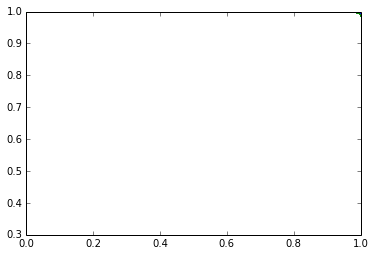

In [23]:
from sklearn.metrics import roc_curve

fpr,tpr,_ = roc_curve(Ytr,model.predict_proba(Xtr)[:,1])
plt.plot(1-fpr,tpr)
fpr,tpr,_ = roc_curve(Yts,model.predict_proba(Xts)[:,1])
plt.plot(1-fpr,tpr)

### Веса простой LR
 * картинка, где каждый пиксель - вес линейной модели для соответствующего пикселя входных данных

<matplotlib.colorbar.Colorbar instance at 0x7fb2ef85c2d8>

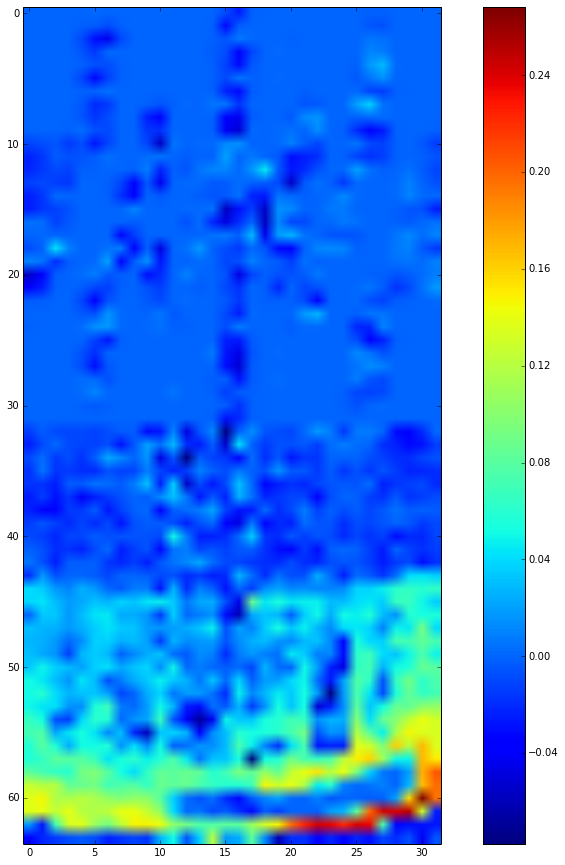

In [24]:
plt.figure(figsize=[15,15])
cfc = np.array(model.coef_)
plt.imshow(cfc.reshape(64,-1))
plt.colorbar()

# Мораль сей басни такова:
* Good ending:
 * Мы более менее умеем отличать события с Ks от неKs
   * оптимальный вариант - MDP-LSTM на 16 ретинах, но различия оказались несущественными
     * а главная проблема - она учится 40 часов
   * SVD-разложение уже не нужно (и даже мешает), когда есть больше данных
 * Следующий этап (делается сейчас) - поиск координат распада Ks
 
 
* Bad ending:
 * Возможно есть косяк в monte-carlo, из-за которого отличать события можно как-то тривиально, и модель к этому сошлась
 * на это есть пара подозрений, сейчас мя мучаю ими бедного Дениса, который думал, что он в отпуске.